<a href="https://colab.research.google.com/github/vacodoceo/vacodoceo-IIC3633-2020/blob/master/practicos/pyRecLab_MostPopular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://youtu.be/MEY4UK4QCP4" target="_parent"><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/YouTube_full-color_icon_%282017%29.svg/71px-YouTube_full-color_icon_%282017%29.svg.png" alt="Open In Colab"/></a>


# Práctica de Sistemas Recomendadores: pyreclab - Most popular e Item average rating. 

En este práctico vamos a utilizar la biblioteca de Python [pyreclab](https://github.com/gasevi/pyreclab), desarrollado por los Laboratorios IALab y SocVis de la Pontificia Universidad Católica de Chile para recomendación no personalizada: **Most Popular** e **Item Average Rating**.




## Configuración inicial 
**Paso 1:** Descargue directamente a Colab los archivos del dataset ejecutando las siguientes 3 celdas:

In [1]:
!curl -L -o "u2.base" "https://drive.google.com/uc?export=download&id=1bGweNw7NbOHoJz11v6ld7ymLR8MLvBsA"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    860      0 --:--:-- --:--:-- --:--:--   860
100 1546k  100 1546k    0     0  1811k      0 --:--:-- --:--:-- --:--:-- 1811k


In [2]:
!curl -L -o "u2.test" "https://drive.google.com/uc?export=download&id=1f_HwJWC_1HFzgAjKAWKwkuxgjkhkXrVg"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    652      0 --:--:-- --:--:-- --:--:--   651
100  385k  100  385k    0     0   417k      0 --:--:-- --:--:-- --:--:--  417k


In [3]:
!curl -L -o "u.item" "https://drive.google.com/uc?export=download&id=10YLhxkO2-M_flQtyo9OYV4nT9IvSESuz"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    854      0 --:--:-- --:--:-- --:--:--   854
100  230k  100  230k    0     0   294k      0 --:--:-- --:--:-- --:--:--  294k


**Paso 2**: Instalamos [`pyreclab`](https://github.com/gasevi/pyreclab) y [`seaborn`](https://seaborn.pydata.org/index.html) utilizando `pip`.

In [4]:
!pip3 install pyreclab --upgrade

     |████████████████████████████████| 235kB 7.9MB/s 


**Paso 3:** Importamos librerías de python que vamos a utilizar

In [5]:
import pandas as pd
import pyreclab
import seaborn as sns
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt

%matplotlib inline
sns.set(style="whitegrid")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Antes de recomendar
**Paso 3**: Los archivos `u2.base` y `u2.test` tienen tuplas (usuario, item, rating, timestamp), que es la información de preferencias de usuarios sobre películas en una muestra del dataset [MovieLens](https://grouplens.org/datasets/movielens/). Revisemos cómo es uno de estos archivos y luego haremos gráficos que nos permitan sacar conclusiones a partir del mismo.

In [6]:
# Primero creamos el dataframe con los datos
df_train = pd.read_csv('u2.base',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)
df_train.head()

,userid,itemid,rating,timestamp
0,1,3,4,878542960
1,1,4,3,876893119
2,1,5,3,889751712
3,1,6,5,887431973
4,1,7,4,875071561


In [7]:
# Ahora queremos realizar una observación rápida de los ratings 
df_train.describe()[['rating']]

,rating
count,80000.000000
mean,3.526463
std,1.124429
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


Por otra parte, para obtener información adicional de cada película tal como **título**, **fecha de lanzamiento**, **género**, etc., cargaremos el archivo de items descargado (`u.item`) para poder mapear cada identificador de ítem al conjunto de datos que lo describe. Revisemos el contenido de este archivo

In [8]:
columns = ['movieid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [9]:
# Cargamos el dataset con los items
df_items = pd.read_csv('u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None, 
                        encoding='latin-1')
df_items.head()

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


Distribución de peliculas por género:

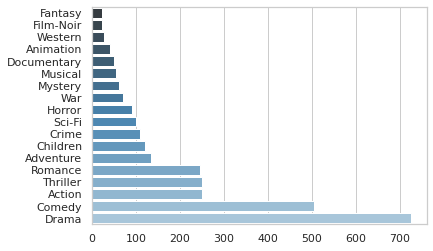

In [10]:
genre_columns = ['Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

genre_count = df_items[genre_columns].sum().sort_values()

sns.barplot(x=genre_count.values, y=genre_count.index, label="Total", palette="Blues_d")

**Pregunta:** Explique cómo funciona most popular y average rating. 
¿Qué problemas podría encontrar al utilizar cada uno de ellos?. 

**Respuesta:**

* *Most Popular*: Consiste en recomendar los *items* más populares, ya sea por *clicks*, visitas, compras, etc... Es muy útil cuando no tenemos información de un usuario y queremos recomendar *items*. El problema que presenta es que no se ajusta a los gustos del usuario.

* *Average Rating*: Consiste en recomendar los *items* con mejor calificación promedio. El principal problema que presenta es recomendar *items* que tengan una califación promedio muy alta debido a una baja muestra de calificaciones, lo cual es solucionable en cierta medida utilizando intervalos de confianza. Al igual que *Most Popular*, no depende de los gustos del usuario y también es útil cuando no hay información de los gustos del usuario.

## Most popular

In [14]:
# Definicion de objeto "most popular"
most_popular = pyreclab.MostPopular(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "most_popular" solo registra los items más populares en el set de entrenamiento  
most_popular.train()

Calculamos métricas de ranking ($nDCG@10$ y $MAP$) para conocer el rendimiento de nuestro recomendador en el set de test. 

1. nDCG@10: normalized discounted cummulative gain @ 10 

$DCG = \sum{ \frac{2^{rel} -1 }{log_2(i+1)}}$

$nDCG = \frac{DCG}{IDCG}$

$IDCG: $ ideal DCG donde todos los relevantes están en las primeras posiciones. 

$nDCG@10$ es la métrica nDCG para los primeros 10 items recomendados. 

2. MAP: mean average precision 

$AveP = \frac{\sum{P(k) * rel(k)}}{total items relevantes}$

$MAP = \sum{\frac{AveP(u)}{U}}$

donde: 
$P(k):$ precision en posicion k (P@10 or "Precision at 10" corresponde al numero de items relevantes en las primeras 10 posiciones) <br>  
$rel(k): $ 0 si el item no es relevante o 1 si es relevante. <br>

**TIP:** relevante por ejemplo es si es que el usuario le dió más de 3 estrellas de rating a un item. <br>



**Ejemplo**

Sistema me recomendó estas 10 películas: 
[13,15,35, 28, 3, 1, 100, 122]

El usuario en realidad prefirió estas películas: 
[13,90,12, 2, 3, 384, 219, 12938]

Construimos lista asignando un 1 si es relevante o 0 si no: <br> 
[1, 0, 0,0,1,0,0,0]

Sobre esta lista calculamos las métricas nDCG@K y MAP (serán vistas en más detalle en clases). 











In [15]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 10

recommendList, maprec, ndcg = most_popular.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.2889129174597905
NDCG@10: 0.1598011823409535


In [18]:
# Calcular las recomendaciones para un usuario en particular (id =2)
user_id = 2

ranking = [int(r) for r in most_popular.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 2: [50, 100, 258, 181, 294, 286, 288, 1, 300, 174]


In [19]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
50,Star Wars (1977),01-Jan-1977,NaN,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
100,Fargo (1996),14-Feb-1997,NaN,http://us.imdb.com/M/title-exact?Fargo%20(1996),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0
258,Contact (1997),11-Jul-1997,NaN,http://us.imdb.com/Title?Contact+(1997/I),0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,NaN,http://us.imdb.com/M/title-exact?Return%20of%2...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
294,Liar Liar (1997),21-Mar-1997,NaN,http://us.imdb.com/Title?Liar+Liar+(1997),0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
286,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0
288,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
300,Air Force One (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Air+Force+One...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0



**Pregunta** Cambiar el id de usuario, qué se puede observar de las recomendaciones?




**Respuesta:**

Cambian algunos resultados. Dado que *Most Popular* no depende de los gustos del usuario, esto solo puede deberse a que no se está recomendando un *item* que el usuario ya ha calificado, por lo que se "salta" este.

## Item average rating 

In [20]:
# Definicion de objeto "item average rating"
item_avg = pyreclab.ItemAvg(dataset='u2.base',
                   dlmchar=b'\t',
                   header=False,
                   usercol=0,
                   itemcol=1,
                   ratingcol=2)

# en teoria no es "entrenar" , objeto "item_average" solo registra los items con mayor rating promedio en el set de entrenamiento  
item_avg.train()

In [21]:
# Testing de recomendaciones sobre los primeros 10 items 
top_n = 10

recommendList, maprec, ndcg = item_avg.testrec(input_file='u2.test',
                                          dlmchar=b'\t',
                                          header=False,
                                          usercol=0,
                                          itemcol=1,
                                          ratingcol=2,
                                          topn=top_n,
                                          relevance_threshold=2,
                                          includeRated=False)

print('MAP: {}\nNDCG@{}: {}'.format(maprec, top_n, ndcg))

MAP: 0.0034456355625600947
NDCG@10: 0.001286715493157526


In [24]:
# Calcular las recomendaciones para un usuario en particular (id =2)
user_id = 1

ranking = [int(r) for r in item_avg.recommend(str(user_id), top_n, includeRated=False)]
print('Recommendation for user {}: {}'.format(user_id, ranking))

Recommendation for user 1: [1653, 1064, 1472, 1599, 1512, 1450, 1536, 1500, 1467, 1293]


In [25]:
# Ver explicitamente las recomendaciones para un usuario determinado
df_items.loc[ranking]

,title,release_date,video_release_date,IMDb_URL,unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movieid,,,,,,,,,,,,,,,,,,,,,,,
1653,Entertaining Angels: The Dorothy Day Story (1996),27-Sep-1996,NaN,http://us.imdb.com/M/title-exact?Entertaining%...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1064,Crossfire (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Crossfire%20(...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
1472,"Visitors, The (Visiteurs, Les) (1993)",19-Jul-1996,NaN,"http://us.imdb.com/M/title-exact?Visiteurs,%20...",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1599,Someone Else's America (1995),10-May-1996,NaN,http://us.imdb.com/M/title-exact?Someone%20Els...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1512,"World of Apu, The (Apur Sansar) (1959)",05-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Apur%20Sansar...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1450,Golden Earrings (1947),01-Jan-1947,NaN,http://us.imdb.com/M/title-exact?Golden%20Earr...,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,NaN,http://us.imdb.com/M/title-exact?Aiqing%20Wans...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,NaN,http://us.imdb.com/M/title-exact?Santa%20with%...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Saint%20of%20...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
